In [61]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML, IFrame, Image, SVG, Latex
import ROOT
from ROOT import RooFit, RooStats

%matplotlib inline

In [9]:
from create_example_ws import create_example

ws = create_example()

# create references to useful variables
model_config = ws.obj('model_config')
pdf = model_config.GetPdf()
obs = model_config.GetObservables()
poi = model_config.GetParametersOfInterest().first()

[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing dataset data_toy_signal
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing dataset data_toy_nosignal


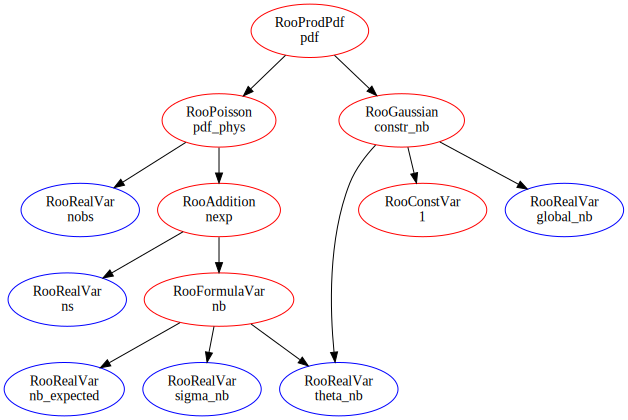

In [4]:
pdf.graphVizTree("pdf_graph.dot")
!dot -Tsvg pdf_graph.dot > pdf_graph.svg; rm pdf_graph.dot
SVG("pdf_graph.svg")

In [28]:
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.Eval) 
ROOT.RooMsgService.instance().setGlobalKillBelow(RooFit.ERROR)
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.NumIntegration) 
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.Fitting) 
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.Minimization) 
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.InputArguments) 
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.Eval) 
ROOT.RooMsgService.instance().setGlobalKillBelow(RooFit.ERROR)
ROOT.RooMsgService.instance().setSilentMode(True);

In [29]:
# create a useful function to create toys specific for this workspace
def create_toy():
    return pdf.generate(obs, 1)

# just an example
data = create_toy()
data.get(0).Print("v")

  1) 0x55b6b6a940a0 RooRealVar:: nobs = 124  L(0 - 13000)  "nobs"


In [39]:
from functools import wraps

def stateless(varnames):
    def decorator(method):
        @wraps(method)
        def f(*args, **kwargs):
            old_values = {v: ws.var(v).getVal() for v in varnames}
            result = method(*args, **kwargs)
            for k, v in old_values.iteritems():
                ws.var(k).setVal(v)
                ws.var(k).setConstant(False)
            return result
        return f
    return decorator

@stateless([poi.GetName()])
def evaluate_test_stat(test_value, data):
   
    # uncond fit
    poi.setConstant(False)
    r = pdf.fitTo(data, RooFit.Save())
    denominator = r.minNll()
    
    # special case, we are not interested in these cases
    if poi.getVal() > test_value:
        return 0.
    
    # recompute if needed
    if poi.getVal() < 0:
        poi.setVal(0)
        poi.setConstant(True)
        r = pdf.fitTo(data, RooFit.Save())
        denominator = r.minNll()
        
    # conditional fit
    poi.setVal(test_value)
    poi.setConstant(True)
    r = pdf.fitTo(data, RooFit.Save())
    numerator = r.minNll()
    
    return numerator - denominator

In [113]:
nsignal_toys = 300
nbkg_toys = 100

test_poi_values = np.linspace(0.1, 300, 5)

all_qvalue_data = {}
all_qvalues_signal_toys = {}
all_qvalues_bkg_toys = {}
all_clsb = {}
all_cls = {}
all_clb = {}

for test_poi_value in test_poi_values:
    print "computing", test_poi_value
    
    qvalue_data = evaluate_test_stat(test_poi_value, data)

    qvalues_signal_toys = []
    qvalues_bkg_toys = []

    for itoy in range(nsignal_toys):
        # create signal-sample toy
        poi.setVal(test_poi_value)
        poi.setConstant(True)
        pdf.fitTo(data)
        poi.setConstant(False)
        toy_s = create_toy()
        qvalues_signal_toys.append(evaluate_test_stat(test_poi_value, toy_s))


    for itoy in range(nbkg_toys):
        # create signal-sample toy
        poi.setVal(0)
        poi.setConstant(True)
        pdf.fitTo(data)
        poi.setConstant(False)
        toy_b = create_toy()
        qvalues_bkg_toys.append(evaluate_test_stat(test_poi_value, toy_b))
    
    
    all_qvalue_data[test_poi_value] = qvalue_data
    all_qvalues_signal_toys[test_poi_value] = np.array(qvalues_signal_toys)
    all_qvalues_bkg_toys[test_poi_value] = np.array(qvalues_bkg_toys)
    
    pvalue_sb = (all_qvalues_signal_toys[test_poi_value] >= qvalue_data).sum() / float(nsignal_toys)
    pvalue_b = (all_qvalues_bkg_toys[test_poi_value] >= qvalue_data).sum() / float(nbkg_toys)
    cls = pvalue_sb / (1 - pvalue_b)
    
    all_clsb[test_poi_value] = pvalue_sb
    all_clb[test_poi_value] = 1 - pvalue_b
    all_cls[test_poi_value] = cls

computing 0.1
computing 75.075
computing 150.05
computing 225.025
computing 300.0


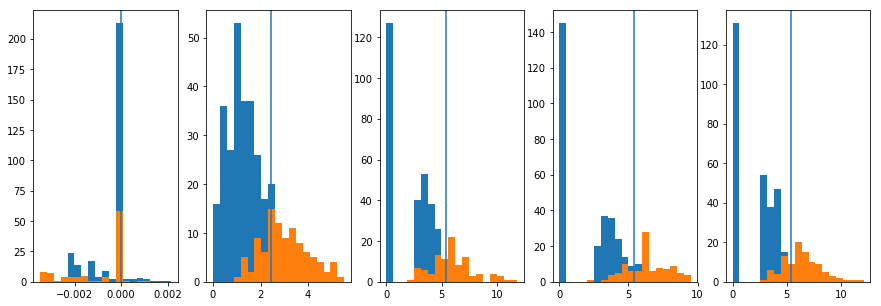

In [114]:
fig, axs = plt.subplots(1, len(test_poi_values), figsize=(15, 5))
for ax, test_poi_value in zip(axs.flat, test_poi_values):
    
    qvalue_data = all_qvalue_data[test_poi_value]
    qvalues_signal_toys = all_qvalues_signal_toys[test_poi_value]
    qvalues_bkg_toys = all_qvalues_bkg_toys[test_poi_value]
    
    bins = np.linspace(min([np.min(qvalues_signal_toys), np.min(qvalues_bkg_toys)]),
                       max([np.max(qvalues_signal_toys), np.max(qvalues_bkg_toys)]), 20)
    ax.hist(qvalues_signal_toys, bins=bins)
    ax.hist(qvalues_bkg_toys, bins=bins)
    ax.axvline(qvalue_data)

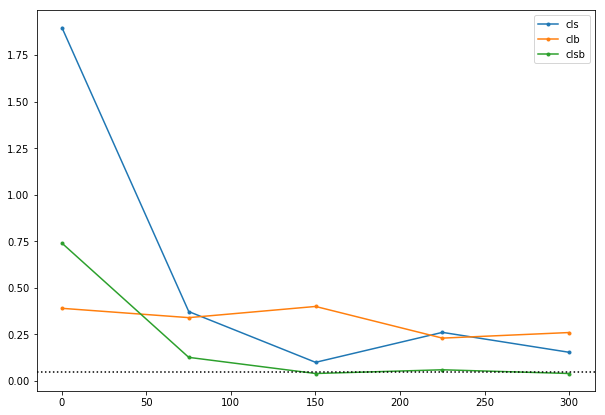

In [115]:
def get_xy(d):
    xs = sorted(d.keys())
    ys = [d[x] for x in xs]
    return xs, ys

fig, ax = plt.subplots(figsize=(10, 7))

x, y = get_xy(all_cls)
ax.plot(x, y, '.-', label='cls')

x, y = get_xy(all_clb)
ax.plot(x, y, '.-', label='clb')

x, y = get_xy(all_clsb)
ax.plot(x, y, '.-', label='clsb')

ax.axhline(0.05, ls=":", color='k')
ax.legend(loc=0)